차원축소:
1. PCA - https://dacon.io/codeshare/4640,
2. matrix decomposition - svd - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html,
3. umap,
4. TSNE

클러스터링:
1. kmeans,
2. dbscan - kmeans처럼 fit만 하면 되는 듯,
3. hdbscan - 깃헙 코드 쓰자: https://github.com/scikit-learn-contrib/hdbscan
https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
4. gmm - 이것도. 하지만 결과가 조금 다르므로 시각화 시 다른 코드 사용: https://romg2.github.io/mlguide/19_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-07.-%EA%B5%B0%EC%A7%91%ED%99%94-GMM/
5.코사인 유사도 방식

스케일링 관련
1. NMF, PCA 등의 차원축소 방식이나 dbscan과 같은 클러스터링 방식은 데이터 스케일링이 필요하지만, 문서 임베딩 값을 스케일링 해버리면 문서의 정보가 사라질 위험이 있으므로 일단 스케일링은 하지 않았다.
2. 또한 직접 임베딩 값을 봐보니 데이터 간 편차가 거의 없었고 단위도 똑같기에 스케일링할 필요를 느끼지 못함.

차원축소 유의점
1. NMF의 경우, 모든 데이터가 양수여야 하기에 무작정 데이터를 스케일링 해버리면 임베딩한 문장의 정보가 날아갈 수 있어서 적용하지는 못할 듯.
2. TSNE는 너무 시간이 오래걸림. 뭔 차원축소가 40분이 넘어도 안되냐

클러스터링 유의점
1. DBSCAN은 클러스터 개수 K를 정할 수가 없어서 일단 결과를 보고 생각해봐야 할 듯.
2. DBSCAN의 epilon은 최대 탐색 거리를 의미하고 min_samples는 최소 샘플 개수를 의미한다. 각 클러스터 별 최소 문서 수는 어떻게 정하고 epsilon값은 또 어떻게 정할까?
3. DBSCAN - RAM 터짐. HDBSCAN - 이거는 수많은 문서 벡터를 -1(outlier)로 치기 때문에 스킵

전체적인 유의점
1. 일단 전부 거리기반으로 짜놓긴 했지만 코사인 기반으로도 비교하는 코드가 있어야 함
2. 파일이름, 폴더 경로 다시 다 수정해야 함

해볼거
1. kmeans, gmm, hdbscan 다 해봐도 됨. gmm빼고는 metric을 전부 코사인 기반으로 해야 한다.
-> 데이터가 유닛벡터이기 때문에 각도로 봐야한다.

2. 휴리스틱
전체 내적 행렬 구해서 거리가 가장 먼 애들끼리 합쳐보고, 가장 가까운 애들끼리 합쳐서 토픽구성
-> 예를 들면 역치는 0.9 이상인거 추려서 합치기. 반대는 -0.9로 해서 두 집단만 봐보기.
얘네한테 angle 기반 kmeans 적용하거나
일단 나눠서 눈으로 보고 잘 되는지 확인. lsa에서 이런식으로 svd 가지고 클러스터를 구성함. == pca가지고도 할 수 ㅣㅇㅆ다
https://www.xlstat.com/en/solutions/features/latent-sementic-analysis-lsa
-> 이거랑 10000개 뽑아서 한거랑 같다


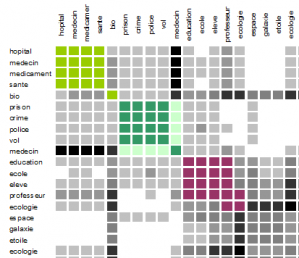

데이터가 너무 많아서 생긴 문제점을 해결하기 위한 삽질들

In [ ]:
import pickle

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/BERT/datas/160000 tweets embedded by sentence-transformers all-distilroberta-v1.txt', 'rb') as f:
  document_embeddings = pickle.load(f)

In [ ]:
document_embeddings.shape #일단 이 데이터는 전부 unit vector -> angle기반 비교가 필요.

(160253, 768)

In [ ]:
np.linalg.norm(document_embeddings[5]) #대부분 1이라 코사인유사도 구할때 자기자신하고 내적만 구하면 됨

1.0

In [ ]:
a = document_embeddings[:10000] #10000개씩 쪼개서 보자 ->vstack
c = np.dot(a, a.T)

In [ ]:
np.argsort(c[0]) #토픽을 만들 때 거리가 가장 먼 애들 기준으로 토픽생성가능. 일단 등간격으로?

array([8363, 6680, 4897, ..., 7242, 1480,    0])

In [ ]:
docs[0], docs[8363]

('future proof google news follow u for latest news twitter reportedly accuses microsoft of violating it data use policy elon musk personal lawyer alex spiro ha reportedly sent microsoft a letter that accuses it of using twitter api',
 'vaseline olive oil or coconut oil are three that work well lot of other remedy google it')

In [ ]:
b = np.linalg.norm(document_embeddings, axis = 1, keepdims = True) #노름

In [ ]:
print(b) #대부분 1 혹은 1에 근접한 값 -> 각각이 unit vector라는 의미

[[1.        ]
 [0.99999994]
 [1.        ]
 ...
 [0.99999994]
 [1.        ]
 [0.99999994]]


(160253, 1)

In [ ]:
np.min(b)

0.9999998

In [ ]:
aaa = np.dot(b, b.T)

In [ ]:
import pandas as pd
#norm(x) * norm(y) -> 160253 * 160253
np.dot(b, b.T) -> RAM 터짐.
pd.DataFrame(b).value_counts값
#b.T[0][0]

1.0    109572
1.0     46547
1.0      2083
1.0      2050
1.0         1
dtype: int64

In [ ]:
#dot(x, y)
#RAM 터짐.
np.dot(document_embeddings, document_embeddings.T)

NameError: ignored

In [ ]:
np.dot(np.linalg.norm(a, axis = 1, keepdims = True), np.linalg.norm(a, axis = 1, keepdims = True).T) #axis 신경써서 이것처럼 곱하면 코사인값 바로 얻을 수 있음.
#np.dot행렬 하나랑 norm*norm 행렬 하나 구해서 계산하면 끝날 듯.

array([[2.44597468, 2.37910192, 2.27175656, 2.18020604],
       [2.37910192, 2.31405746, 2.20964691, 2.12059937],
       [2.27175656, 2.20964691, 2.10994739, 2.02491768],
       [2.18020604, 2.12059937, 2.02491768, 1.94331462]])

SVD 개념 학습

In [ ]:
from sklearn.decomposition import TruncatedSVD

TruncatedSVD(n_components = 2).fit_transform(a)

np.

array([[ 1.33149204,  0.80550344],
       [ 1.37683765, -0.13577743],
       [ 1.29438114, -0.56509041],
       [ 1.1962439 , -0.12884962]])

In [ ]:
q,w,r = np.linalg.svd(a)
np.dot(q[:, :2], np.diag(w[:2]))

array([[-1.33149204, -0.80550344],
       [-1.37683765,  0.13577743],
       [-1.29438114,  0.56509041],
       [-1.1962439 ,  0.12884962]])

In [ ]:
np.dot(np.diag(w[:2]), r[:2]).T

array([[-1.09856559, -0.52976341],
       [-0.94409928, -0.29491294],
       [-0.94068315,  0.18138878],
       [-1.02688938,  0.6426086 ],
       [-1.41598217, -0.20965259],
       [-0.85581136,  0.38180607]])

In [ ]:
np.dot(q[:, :2], np.diag(w[:2])).dot(r[:2]), a

(array([[0.98801185, 0.72012438, 0.33532672, 0.00850416, 0.89294634,
         0.13073181],
        [0.50929028, 0.45941912, 0.52217988, 0.63030342, 0.72058773,
         0.50445417],
        [0.24741764, 0.30310321, 0.57012823, 0.87321239, 0.58586798,
         0.64099556],
        [0.43673348, 0.39595515, 0.45565847, 0.55461068, 0.6237937 ,
         0.44243513]]),
 array([[0.9796108 , 0.67229546, 0.40662836, 0.04275107, 0.9311538 ,
         0.01159719],
        [0.77966832, 0.64849972, 0.1987075 , 0.89325168, 0.38118084,
         0.5504006 ],
        [0.23664488, 0.20204432, 0.71955929, 0.95729355, 0.66105535,
         0.37676782],
        [0.14654459, 0.34091558, 0.5869115 , 0.12286794, 0.89055715,
         0.80806076]]))

클러스터링 코드


In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentence-transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import logging
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sentence_transformers import models

In [ ]:
import scipy
import numpy  as np
import pickle
import matplotlib.pyplot as plt
import os

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import umap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#이 부분 자기 폴더 경로에 맞게 바꾸기
%cd drive/My\ Drive/Colab\ Notebooks/BERT/datas

/content/drive/My Drive/Colab Notebooks/BERT/datas


In [ ]:
import sqlite3
import pandas as pd

db = sqlite3.connect('preprocgoogle.db')

df = pd.read_sql_query("select preproc from tweet", db)

In [ ]:
docs = df['preproc']

In [ ]:
#필요한 파일 다운로드 - 자기 모델에 맞는 파일명 찾아서 다운로드 하세용

#모델별 임베딩파일
#160000 tweets embedded by bert-base-uncased.txt
!gdown 1DX5sLbWbq_2YM5FoRMmtofLNII7g-Px7
#160000 tweets embedded by sentence-transformers all-distilroberta-v1.txt
!gdown 177LMKC4m7BkYJ8lKN-IKdf5MlThSuVTJ
#160000 tweets embedded by sentence-transformers all-mpnet-base-v2.txt
!gdown 1-1TJxaTfFYVlsLIWypvID0AOrglIEcWf
#160000 tweets embedded by sentence-transformers multi-qa-distilbert-cos-v1.txt
!gdown 11vMhVNXfFTHKgDO6yJvf54aocq8Js-uS

#db파일
!gdown 14cQBvEzxZl0UF3zuRLj26c2bu3BTWM6m

In [ ]:
import gc
gc.collect()

184658

In [ ]:
#클러스터 그래프가 엄청 이쁘게 나오는 이유는 이것들이 쿼리이기 때문.

from numpy.linalg import norm
%matplotlib inline

def cosine(x, y):
  return np.dot(x, y)/(norm(x) * norm(y))


def get_scores(X, labels):
  CHI = calinski_harabasz_score(X, labels)
  DBI = davies_bouldin_score(X, labels)
  return (CHI, DBI)

#영준 - 'sentence-transformers/multi-qa-distilbert-cos-v1'
#중석 - "sentence-transformers/all-distilroberta-v1"
#현욱 - "bert-base-uncased"
#밑에 model_list에 자기꺼 하나만 넣어서 돌리기
# 'sentence-transformers/multi-qa-distilbert-cos-v1', "sentence-transformers/all-distilroberta-v1", "bert-base-uncased"
model_list = ["sentence-transformers/all-mpnet-base-v2"]
#'PCA',
DR_list = ['SVD', 'UMAP']
# 'dbscan', , 'hdbscan'
clustering_list = ['kmeans', 'gmm']

for name in model_list:
  model_name = name
  embedding_model = models.Transformer(model_name)
  pooler = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=True,
    pooling_mode_max_tokens=False,
  )
  model = SentenceTransformer(model_name)
  model_name_re = ' '.join(model_name.split('/'))

  #자기 폴더 경로에 맞게 바꾸기
  with open('/content/drive/MyDrive/Colab Notebooks/BERT/datas/160000 tweets embedded by '+ model_name_re + '.txt', 'rb') as f:
    document_embeddings = pickle.load(f)

  #자기 폴더 경로에 맞게 바꾸기
  directory = "/content/drive/MyDrive/Colab Notebooks/BERT/results/" +  model_name_re
  os.mkdir(directory)

  for DR_name in DR_list:
    dr_directory = directory + '/' +' DR: ' + DR_name
    os.mkdir(dr_directory)

    #PCA는 공분산을 이용해서 데이터의 분포와 단위가 다르면 스케일링 할 필요가 있지만 임베딩된 데이터를 살펴보니 그럴 필요가 없어보임
    if DR_name == 'PCA':
      X = PCA(n_components=2).fit_transform(document_embeddings)

    #너무 오래 걸린다 이거는
    #elif DR_name == 'TSNE':
    #  X = TSNE(n_components = 2).fit_transform(document_embeddings)

    elif DR_name == 'SVD':
      X = TruncatedSVD(n_components = 2).fit_transform(document_embeddings)

    elif DR_name == 'UMAP':
      X = umap.UMAP().fit_transform(document_embeddings)

    for clustering_name in clustering_list:
      if DR_name == 'SVD' and clustering_name == 'kmeans':
        continue
      cluster_directory = dr_directory + '/' + 'cluster: ' + clustering_name
      os.mkdir(cluster_directory)

      text_folder = cluster_directory + '/' + 'sentences'
      image_folder = cluster_directory + '/' + 'images'
      os.mkdir(text_folder)
      os.mkdir(image_folder)

      if clustering_name == 'dbscan':

        #이 부분 반복문으로 eps하고 min_samples 변화시켜야 함
        dbscan = DBSCAN(eps=0.5, min_samples=2)
        dbscan.fit(X)
        cluster_assignment = dbscan.labels_
        cls_dist=pd.Series(cluster_assignment).value_counts()

        #이 부분 일단 클러스터 중심을 뽑을 수가 있어서 거리기반으로 재봤는데 코사인 기반으로도 해봐야 할 듯
        distances = scipy.spatial.distance.cdist(dbscan.core_sample_indices_, X)
        centers={}

        f = open(text_folder + '/' + str(num_clusters) + ' clusters' + '.txt', 'w')

        #각 지표별 score 구하기
        CHI, DBI = get_scores(X, dbscan.labels_)

        f.write(f'davies_bouldin_score: {DBI}, calinski_harabasz_score: {CHI}')
        f.write('\n')
        f.write('#####################################')
        f.write('\n')
        #거리 순으로 오름차순 정렬
        for j, d in enumerate(distances):
          f.write(str(j) + '번째 클러스터')
          f.write('-----------------------------------')
          f.write('\n')
          ind = np.argsort(d, axis=0)[:20]
          for i, idx in enumerate(ind):
            f.write(str(i) + '번째로 가까운 문장: ' + docs[idx])
            f.write('\n')
          f.write('\n')
        f.close()

        labels= dbscan.labels_
        fig, ax = plt.subplots(figsize=(12,12))
        plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
        plt.title('model: ' + model_name + ', clusters: ' + str(num_clusters) + ', DR: ' + DR_name + ', cluster: ' + clustering_name)
        plt.colorbar()
        plt.savefig(image_folder + '/' + 'number of cluster: ' + str(num_clusters) + '.png')

      else:

        for num_clusters in range(5, 16):

          if clustering_name == 'kmeans':
            k_means = KMeans(n_clusters=num_clusters)
            k_means.fit(X)
            cluster_assignment = k_means.labels_
            cls_dist=pd.Series(k_means.labels_).value_counts()

            clustered_sentences = [[] for _ in range(num_clusters)]

            for sentence_id, cluster_id in enumerate(cluster_assignment):
                clustered_sentences[cluster_id].append(docs[sentence_id])

            distances = scipy.spatial.distance.cdist(k_means.cluster_centers_, X)
            centers={}

            f = open(text_folder + '/' + str(num_clusters) + ' clusters' + '.txt', 'w')

            #각 지표별 score 구하기
            CHI, DBI = get_scores(X, k_means.labels_)

            f.write(f'davies_bouldin_score: {DBI}, calinski_harabasz_score: {CHI}')
            f.write('\n')
            f.write('#####################################')
            f.write('\n')


            for j, d in enumerate(distances):
              f.write(str(j) + '번째 클러스터')
              f.write('-----------------------------------')
              f.write('\n')

              ind = np.argsort(d, axis=0)[:20]
              center = ind[0]

              for i, idx in enumerate(ind):
                f.write(str(i) + '번째로 가까운 문장: ' + docs[idx])
                f.write('\n')

              f.write('\n')
              for i, idx in enumerate(ind):
                f.write('중심 문장: ' + docs[center])
                f.write('\n')

                a = []
                target = document_embeddings[center]

                for idx, sentence in enumerate(document_embeddings):
                  a.append((cosine(target, sentence), idx))

                a.sort(key = lambda x: x[0], reverse = True)

                #자기 자신과 코사인 유사도 계산한게 1로 a에서 가장 위로 올 것이므로 인덱스는 1부터 시작
                for idx in range(1, 11):
                  f.write(str(idx) + '번째로 유사도가 높은 문장' +  ': ' + docs[a[idx][1]])
                  f.write('\n')
                  f.write('코사인 유사도: ' + str(a[idx][0]))
                  f.write('\n')

                f.write('#####################################')
                f.write('\n')
                for idx in range(1, 11):
                  f.write(str(idx) + '번째로 유사도가 낮은 문장' +  ': ' + docs[a[-idx][1]])
                  f.write('\n')
                  f.write('코사인 유사도: ' + str(a[-idx][0]))
                  f.write('\n')

                f.write('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
              f.write('\n')
            f.close()

            labels= k_means.labels_
            fig, ax = plt.subplots(figsize=(12,12))
            plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
            plt.title('model: ' + model_name + ', clusters: ' + str(num_clusters) + ', DR: ' + DR_name + ', cluster: ' + clustering_name)
            plt.colorbar()
            plt.savefig(image_folder + '/' + 'number of cluster: ' + str(num_clusters) + '.png')

          elif clustering_name == 'hdbscan':
            hdbscan = hdbscan.HDBSCAN(min_cluster_size=num_clusters)
            cluster_assignment = hdbscan.fit_predict(X)

            cls_dist=pd.Series(cluster_assignment).value_counts()
            clusters = np.unique(cls_dist.index)

            clustered_sentences = [[] for _ in range(num_clusters)]

            for sentence_id, cluster_id in enumerate(cluster_assignment):
                clustered_sentences[cluster_id].append(docs[sentence_id])

             #각 지표별 score 구하기
            CHI, DBI = get_scores(X, hdbscan.labels_)

            f = open(text_folder + '/' + str(num_clusters) + ' clusters' + '.txt', 'w')

            f.write(f'davies_bouldin_score: {DBI}, calinski_harabasz_score: {CHI}')
            f.write('\n')
            f.write('#####################################')
            f.write('\n')

            for cluster in clusters:
              f.write(str(cluster) + '번째 클러스터')
              f.write('-----------------------------------')
              f.write('\n')

              for idx, sentence in enumerate(clustered_sentences[cluster][:20]):
                f.write(str(idx) + '번째 문장: ' + sentence)
                f.write('\n')
              f.write('\n')
            f.close()

            labels= hdbscan.labels_
            fig, ax = plt.subplots(figsize=(12,12))
            plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
            plt.title('model: ' + model_name + ', clusters: ' + str(num_clusters) + ', DR: ' + DR_name + ', cluster: ' + clustering_name)
            plt.colorbar()
            plt.savefig(image_folder + '/' + 'number of cluster: ' + str(num_clusters) + '.png')

          elif clustering_name == 'gmm':
            gmm = GaussianMixture(n_components=num_clusters)
            gmm.fit(X)
            cluster_assignment = gmm.predict(X)
            cls_dist=pd.Series(cluster_assignment).value_counts()
            clusters = np.unique(cls_dist.index)

            clustered_sentences = [[] for _ in range(num_clusters)]
            sentence_indices = [[] for _ in range(num_clusters)]

            number_of_sentences = 20

            for sentence_id, cluster_id in enumerate(cluster_assignment):
                clustered_sentences[cluster_id].append(docs[sentence_id])
                #일단 number_of_sentences개씩 밑에서 보여주므로 number_of_sentences개 문장을 저장한다.
                if len(sentence_indices[cluster_id]) < number_of_sentences:
                  sentence_indices[cluster_id].append(sentence_id)

            #GMM은 군집 별 중심이 없기 때문에 그냥 클러스터 내의 텍스트만 뽑아내자
            f = open(text_folder + '/' + str(num_clusters) + ' clusters' + '.txt', 'w')

            #각 지표별 score 구하기
            CHI, DBI = get_scores(X, cluster_assignment)

            f.write(f'davies_bouldin_score: {DBI}, calinski_harabasz_score: {CHI}')
            f.write('\n')
            f.write('#####################################')
            f.write('\n')

            for cluster in clusters:
              f.write(str(cluster) + '번째 클러스터')
              f.write('-----------------------------------')
              f.write('\n')

              for idx, sentence in enumerate(clustered_sentences[cluster][:number_of_sentences]):
                nth_sentence_idx = sentence_indices[cluster][idx]

                f.write(str(idx) + '번째 문장: ' + sentence)
                f.write('\n')

                a = []
                target = document_embeddings[nth_sentence_idx]

                for idx, sentence in enumerate(document_embeddings):
                  a.append((cosine(target, sentence), idx))

                a.sort(key = lambda x: x[0], reverse = True)

                for idx in range(1, 7):
                  f.write(str(idx) + '번째로 유사도가 높은 문장' +  ': ' + docs[a[idx][1]])
                  f.write('\n')
                  f.write('코사인 유사도: ' + str(a[idx][0]))
                  f.write('\n')

                f.write('#####################################')
                f.write('\n')

                for idx in range(1, 7):
                  f.write(str(idx) + '번째로 유사도가 낮은 문장' +  ': ' + docs[a[-idx][1]])
                  f.write('\n')
                  f.write('코사인 유사도: ' + str(a[-idx][0]))
                  f.write('\n')

                f.write('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

              f.write('\n')
            f.close()

            labels= cluster_assignment
            fig, ax = plt.subplots(figsize=(12,12))
            plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
            plt.title('model: ' + model_name + ', clusters: ' + str(num_clusters) + ', DR: ' + DR_name + ', cluster: ' + clustering_name)
            plt.colorbar()
            plt.savefig(image_folder + '/' + 'number of cluster: ' + str(num_clusters) + '.png')



In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/BERT/datas/160000 tweets embedded by ' + 'sentence-transformers all-mpnet-base-v2.txt', 'rb') as f:
    document_embeddings = pickle.load(f)

X = PCA(n_components=2).fit_transform(document_embeddings)

a = hdbscan.HDBSCAN(min_cluster_size = 8)
cluster_assignment = a.fit_predict(X)

print(cluster_assignment)


[  -1   -1   -1 ...   -1   -1 3035]


In [ ]:
print(cluster_assignment.value_counts())

AttributeError: ignored